Когда мы проходили ряды у нас также была тема ряды и вероятности \\
Проходя нормальное распределение я задался достаточно очевидным вопросом: "Откуда вообще появилась такая формула?". На этот вопрос Сергей Евгеньевич очень полно ответил на черном семинаре, рассказав про ЦПТ. \\
Вы можете посчитать ,что эта тема лишь косвенна к матану и все же про теорию вероятностей. Вы будете абсолютно правы! Но меня красота этой темы не может оставить равнодушной, поэтому я реализовал интерактивное проявление ЦПТ

In [4]:
# Данная библиотека нужна мне для интерактивности графиков, так как в колабе matplotlib ограничен
!pip install ipympl

In [1]:
# Тоже для интерактивности графиков
%matplotlib widget

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from ipywidgets import Button


# Класс для рисования графиков

class InteractiveDrawer:
    def __init__(self):
        self.x = []
        self.y = []
        self.drawing = False

        # Фиксированный диапазон
        self.xmin, self.xmax = -20, 20
        self.ymin, self.ymax = -20, 20

        # Создаём график
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot([], [], 'r-', lw=2)
        self.ax.set_xlim(self.xmin, self.xmax)
        self.ax.set_ylim(self.ymin, self.ymax)
        self.ax.set_title("Рисуйте график внутри [-20, 20] x [-20, 20]")
        self.ax.grid(True)

        #События мыши
        self.cid_press = self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.cid_move = self.fig.canvas.mpl_connect('motion_notify_event', self.on_move)
        self.cid_release = self.fig.canvas.mpl_connect('button_release_event', self.on_release)

        # Кнопка завершения
        self.end_button = Button(description="Завершить")
        self.end_button.on_click(self.finish_drawing)
        display(self.end_button)

        plt.show(self.fig)

    def on_press(self, event):
        if event.inaxes == self.ax:
            self.drawing = True
            self.x.clear()
            self.y.clear()
            self.line.set_data([], [])
            self.fig.canvas.draw_idle()

    def on_move(self, event):
        if self.drawing and event.inaxes == self.ax and event.xdata is not None and event.ydata is not None:
            self.x.append(event.xdata)
            self.y.append(event.ydata)
            self.line.set_data(self.x, self.y)
            self.fig.canvas.draw_idle()  # метод нагуглил - для оптимизации

    def on_release(self, event):
        if event.button == 1:
            self.drawing = False

    def finish_drawing(self, button=None):
        self.fig.canvas.mpl_disconnect(self.cid_press)
        self.fig.canvas.mpl_disconnect(self.cid_move)
        self.fig.canvas.mpl_disconnect(self.cid_release)
        self.end_button.disabled = True

        self.df = pd.DataFrame({'x': self.x, 'y': self.y})

        print("Распределение задано успешно!")


Button(description='Завершить', style=ButtonStyle())

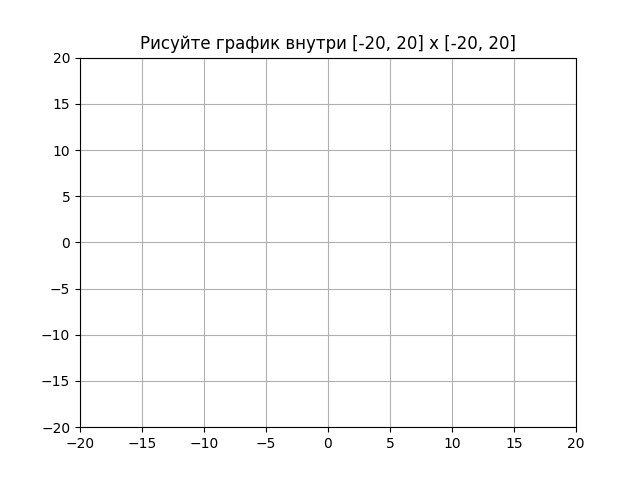

Распределение задано успешно!


In [22]:
from google.colab import output
output.enable_custom_widget_manager()
drawer = InteractiveDrawer()

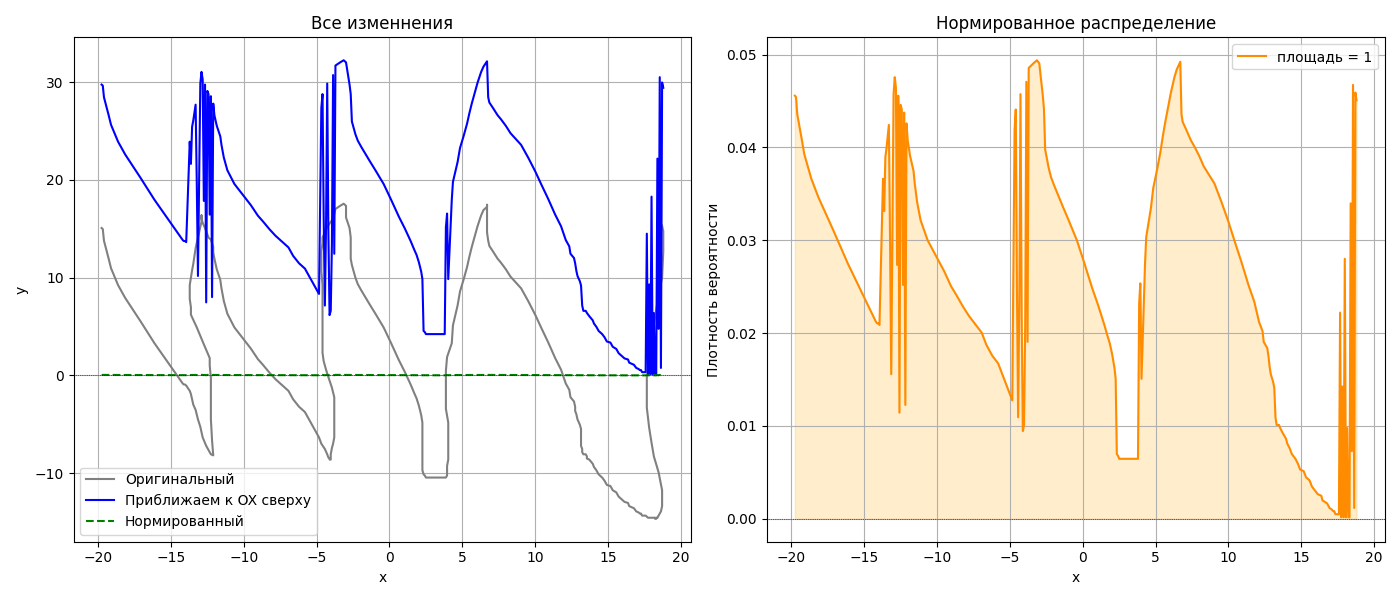

In [23]:
import numpy as np

df = drawer.df.copy()

#Сдвигаем график вверх так, чтобы все значения y были >= 0
df['y_shifted'] = df['y'] - df['y'].min() + 1e-8

# Могло выйти так, что одному x соответсвует несколько y. Будем брать максимум
df = df.groupby('x')['y_shifted'].max().reset_index()
df = df.sort_values(by='x').reset_index(drop=True)

# Численное интегрирование для нахождения площади, замечу, что тут по другому никак (скорее всего руками вы нарисовали всюду недифференцируемый график)
area = np.trapezoid(df['y_shifted'], x=df['x'])

# Нормируем, чтобы распределение можно было назвать случайной величиной
df['y_normalized'] = df['y_shifted'] / area

# График 1: Оригинал, сдвинутый и нормированный
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(drawer.df['x'], drawer.df['y'], label='Оригинальный', color='gray')
plt.plot(df['x'], df['y_shifted'], label='Приближаем к OX сверху', color='blue')
plt.plot(df['x'], df['y_normalized'], label='Нормированный', color='green', linestyle='--')
plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.title("Все изменнения")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# График 2: Только нормированное распределение
plt.subplot(1, 2, 2)
plt.plot(df['x'], df['y_normalized'], label='площадь = 1', color='darkorange')
plt.fill_between(df['x'], df['y_normalized'], alpha=0.2, color='orange')
plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.title("Нормированное распределение")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

На первом графике может показаться, что наш полученный график всюду 0, это не так, просто он очень маленький) \\

Давайте убедимся, что площадь правда 1

In [24]:
area = np.trapezoid(df['y_normalized'], x=df['x'])
assert area.__round__(5) == 1
print(f"Площадь под графиком: {area:.5f}")

Площадь под графиком: 1.00000


Отлично, мы почти у цели! \\
Центральная предельная теорема в сути говорит: если брать много выборок из любого распределения и считать их средние, то распределение этих средних будет приближаться к нормальному — даже если исходное распределение не нормальное.

Распределение мы получили, давайте теперь засемплим (получим выборку из распределения)
Мы умеем генерить вероятности (rand.rand()), так почему бы не использвать CDF? \\
Создадим функцию, которая принимает массив чисел от 0 до 1 и возвращает соответствующие значения случайной величины, распределённой по заданному произвольному закону (в данном случае — наш чудестный холст) \\
Но сначала еще озаботимся вопросом корректности: можно ли так?

---

## Дано

Пусть $ p(x) $ — плотность распределения вероятности на $ \mathbb{R} $, такая что:
$$
\int_\limits{-\infty}^{\infty} p(x)\, dx = 1
$$

## Определим кумулятивную функцию распределения (CDF):
$$
F(x) := \int_\limits{-\infty}^{x} p(t)\, dt
$$

Свойства:
- $ F: \mathbb{R} \to [0, 1] $,
- $ F $ — неубывающая (очевидно верно, так как вероятность неотрицательна),
- $ F(-\infty) = 0,\quad F(\infty) = 1 $.

## Обратная CDF:
Определим обратную функцию:
$$
F^{-1}(p) := \inf \left\{ x \in \mathbb{R} \mid F(x) \geq p \right\}, \quad p \in (0, 1).
$$
Рассмотрим теперь случайную величину $X := F^{-1}(U)$. \\
Так как $ F^{-1}(p) $ — минимальное значение $ x $, для которого $ F(x) \geq p$
$$
F^{-1}(U) \leq x \iff U \leq F(x),
$$
Следовательно:
$$
\mathbb{P}(F^{-1}(U) \leq x) = \mathbb{P}(U \leq F(x)) = F(x),
$$
то есть случайная величина $ X = F^{-1}(U) $ имеет распределение с плотностью $ p(x) $.
$$
\mathbb{P}(X \leq x) = \mathbb{P}(F^{-1}(U) \leq x) = \mathbb{P}(U \leq F(x)) = F(x),
$$
а значит, $ X \sim p(x) $.

Отлично, мы доказали корректность метода обратного преобразования для генерации случайных чисел с заданным распределением.

Сформулируем алгоритм \\
Чтобы сгенерировать выборку $ X_1, ..., X_N \sim p(x) $:
1. Пострим $ F(x) $ по $ p(x) $.
2. Пострим $ F^{-1}(p) $.
3. Сгенерируем $ U_i \sim \text{Uniform}(0, 1),\ i=1..N $.
4. Вычислим $ X_i = F^{-1}(U_i) $.

In [25]:
from scipy.interpolate import interp1d

# 1. Построим CDF по плотности p(x)
# интересно, что вместо интегрирования какой-то функции, мы используем cumsum, что в целом дает тоже самое значение с некоторой погрешностью
def build_cdf(df):
    x = df['x'].values
    p = df['y_normalized'].values
    dx = np.diff(x).mean()  # Средний шаг по x
    cdf = np.cumsum(p) * dx  # Интеграл численно
    cdf /= cdf[-1]  # Нормировка к 1
    return (
        interp1d(x, cdf, bounds_error=False, fill_value=(0, 1)),
        interp1d(cdf, x, bounds_error=False, fill_value="extrapolate")
    )

In [28]:
def generate_sample(sample_size):
    U = np.random.rand(sample_size)
    return inverse_cdf_func(U)

Чтобы наглядно увидеть всю ЦПТ я написал анимацию этого \\
Функция update - ключевая в анимации, но в ней лучше не трогать параметры)

In [29]:
def update(frame):
    global all_means

    # Генерируем одну выборку и считаем среднее
    sample = generate_sample(sample_size)
    mean = np.mean(sample)
    all_means.append(mean)

    # левый гарфик выборка и среднее
    ax_left.cla()
    ax_left.plot(df['x'], df['y_normalized'], 'k-', lw=2, alpha=0.3, label='Исходное p(x)')
    ax_left.scatter(sample, np.zeros_like(sample), c='blue', s=40, label='Точки из p(x)')
    ax_left.scatter([mean], [0], c='red', s=80, label='Среднее по выборке')
    if len(all_means) > 1:
        last_mean = all_means[-1]
        ax_left.scatter([last_mean], [0], c='orange', s=100, edgecolor='black', linewidth=1.5, label='Последнее среднее')
    ax_left.set_xlim(df['x'].min(), df['x'].max())
    ax_left.set_ylim(-0.05, df['y_normalized'].max()+0.05)
    ax_left.set_title("Выборка из p(x) + среднее")
    ax_left.set_yticks([])
    ax_left.legend()
    ax_left.grid(True)

    # правый график: гистограмма средних
    counts, _ = np.histogram(all_means, bins=bin_edges, density=True)

    for i, rect in enumerate(bin_patches):
        rect.set_height(counts[i])
        rect.set_color('lightgreen')

    # Найдём, в какой бин попало последнее среднее
    last_mean = all_means[-1]
    bin_index = np.digitize(last_mean, bin_edges) - 1
    if 0 <= bin_index < len(bin_patches):
        bin_patches[bin_index].set_color('orange')

    # Нормальная аппроксимация
    if len(all_means) > 1:
        mu, sigma = np.mean(all_means), np.std(all_means)
        y_norm = norm.pdf(x_norm, mu, sigma)
        mu_line.set_data(x_norm, y_norm)
        ax_right.legend([mu_line], [f'Нормальное\nμ={mu:.4f}, σ={sigma:.4f}'])
    else:
        mu_line.set_data([], [])

    # Автомасштабирование Y
    max_count = max(counts) if len(counts) > 0 else 1
    ax_right.set_ylim(0, max_count * 1.2)

    return list(bin_patches) + [mu_line]


Главный код \\
Тут можно настроить параметры для вашей анимации, а также выбрать сколько значений в подвыборках и сколько раз нам их генерировать  \\
NB! При генерации могут наблюдать лаги анимации (скорее всего будут), поэтому я сохраняю анимацию в **animation.mp4**, можете помле скачать и посмотреть без лагов \\
Генерация достаточно долгая (!)

Анимация сохранена: animation.mp4


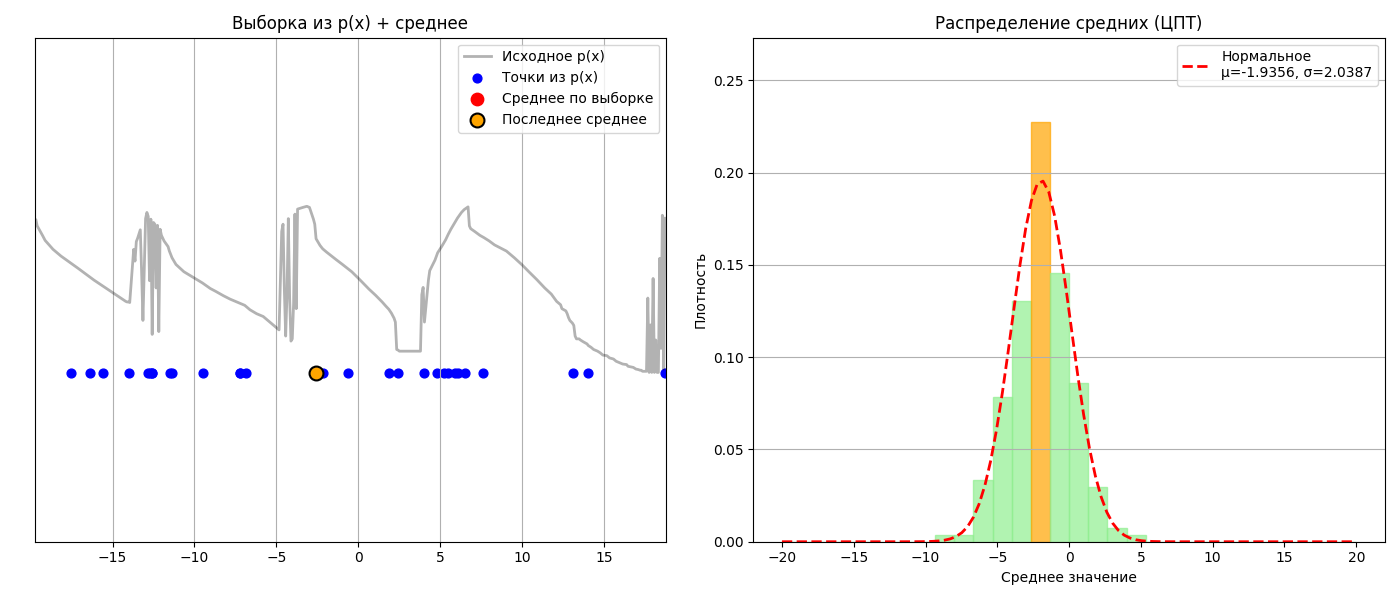

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from scipy.stats import norm

cdf_func, inverse_cdf_func = build_cdf(df)

# = = = = = = = Вот настройки = = = = = = =
n_frames = 200            # Число кадров анимации
sample_size = 30          # Размер каждой выборки
samples_per_frame = 1     # Сколько новых средних за кадр
interval_ms = 100         # Задержка между кадрами (в миллисекундах)
# = = = = = = = = = = = = = = = = = = = = =

all_means = []                # Все средние — для основного графика

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(14, 6))

# График 1: исходное распределение + текущая выборка + среднее
ax_left.plot(df['x'], df['y_normalized'], 'k-', lw=2, alpha=0.3, label='Исходное p(x)')
sample_points = ax_left.scatter([], [], c='blue', s=40, label='Точка из p(x)')
mean_point = ax_left.scatter([], [], c='red', s=80, label='Среднее')
last_mean_point = ax_left.scatter([], [], c='orange', s=100, edgecolor='black', linewidth=1.5, label='Последнее среднее')
ax_left.set_title("Выборка из p(x) + среднее")
ax_left.set_xlabel("x")
ax_left.set_ylabel(" ")
ax_left.set_yticks([])
ax_left.grid(True)
ax_left.legend()

# График 2: распределение средних
bins = 30
bin_edges = np.linspace(-20, 20, bins + 1)
bin_patches = ax_right.bar(bin_edges[:-1], np.zeros(bins), width=np.diff(bin_edges), edgecolor='black', align="edge", color='lightgreen', alpha=0.7)
mu_line, = ax_right.plot([], [], 'r--', lw=2, label="Нормальное")
last_bin_rect = ax_right.bar([], [], color='orange', alpha=0.8, width=0)  # Для подсветки ластового

ax_right.set_title("Распределение средних (ЦПТ)")
ax_right.set_xlabel("Среднее значение")
ax_right.set_ylabel("Плотность")
ax_right.grid(True, axis='y')
ax_right.legend([mu_line], ['Нормальное'])

plt.tight_layout()

x_norm = np.linspace(-20, 20, 100)
bin_edges = np.linspace(-20, 20, bins + 1)

ani = FuncAnimation(fig, update, frames=n_frames, repeat=False, interval=interval_ms)

output_path = 'animation.mp4'
ani.save(output_path, writer='ffmpeg', fps=2)

print(f"Анимация сохранена: {output_path}")

Отлично!, мы видим что действительно данные распределены нормально, давайте посчитаем по исходному распределению матожидание и дисперсию и кое-что проверим)

Матожидание и дисперсию можно посчитать Методом Монте-Карло (просто кучу раз повторить))) \\
$$\mathbb{E}[X] \approx \frac{1}{n} \sum_{i=1}^{n} X_i,\quad X_i \sim p(x)$$

In [20]:
def monte_carlo_expectation(inverse_cdf_func, sample_size=10000):
    U = np.random.rand(sample_size)
    X = inverse_cdf_func(U)
    return np.mean(X)

mean_mc = monte_carlo_expectation(inverse_cdf_func, sample_size=50000)
print(f"Оценка мат. ожидания методом Монте-Карло: {mean_mc:.4f}")

Оценка мат. ожидания методом Монте-Карло: -7.1146
Оценка дисперсии методом Монте-Карло: 115.2082


Но стоп, это же в точности то же самаое среднее, что и у норм распределения в нашей анимации!

In [18]:
print(f"Математическое ожидание (μ): {np.mean(all_means):.4f}")

Математическое ожидание (μ): -7.1837
Стандартное отклонение (σ): 1.8465


Советую поиграть и порисовать разные распределения! \\
Можно также задать функцией df, а не рисовать


Ну и конечно, само доказательство ЦПМ. (Было на черном матане 🐱) \\

Дано: \\
Пусть $ X_1, X_2, \dots, X_n $ — независимые одинаково распределённые случайные величины с:
$$
\mathbb{E}[X_i] = \mu,\quad \mathrm{Var}(X_i) = \sigma^2 > 0.
$$

Обозначим выборочное среднее:
$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} X_i.
$$

Тогда при $ n \to \infty $:
$$
Z_n = \frac{\bar{X}_n - \mu}{\sigma / \sqrt{n}} \xrightarrow{d} \mathcal{N}(0, 1).
$$

Введём центрированные величины:
$$
Y_i = \frac{X_i - \mu}{\sigma},\quad \mathbb{E}[Y_i] = 0,\quad \mathrm{Var}(Y_i) = 1.
$$

Рассмотрим нормированную сумму:
$$
Z_n = \frac{1}{\sqrt{n}} \sum_{i=1}^{n} Y_i.
$$

Характеристическая функция $ Z_n $:
$$
\varphi_{Z_n}(t) = \left( \varphi_Y\left( \frac{t}{\sqrt{n}} \right) \right)^n.
$$

Разложим $ \varphi_Y(t) $ в ряд Тейлора в окрестности $ t = 0 $:
$$
\varphi_Y(t) = 1 - \frac{t^2}{2} + o(t^2),\quad t \to 0.
$$

Подставляем:
$$
\varphi_{Z_n}(t) = \left(1 - \frac{t^2}{2n} + o\left(\frac{t^2}{n}\right)\right)^n \to e^{-t^2/2},\quad n \to \infty.
$$

Функция $ e^{-t^2/2} $ — характеристическая функция $ \mathcal{N}(0, 1) $.  
Следовательно:
$$
Z_n \xrightarrow{d} \mathcal{N}(0, 1).
$$

---
P.s. Хар. функций в основном курсе не было, но другого док-ва я не знаю)

Спасибо за внимание!